In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install 'aif360[all]'


from collections import OrderedDict

import sys

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset, BinaryLabelDataset

# Fairness preprocessing
from aif360.algorithms.preprocessing import Reweighing

# Alzheimer Dataset

         Group M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0  Nondemented   M   87    14  2.0  27.0  0.0  1987  0.696  0.883
1  Nondemented   M   88    14  2.0  30.0  0.0  2004  0.681  0.876
2     Demented   M   75    12  NaN  23.0  0.5  1678  0.736  1.046
3     Demented   M   76    12  NaN  28.0  0.5  1738  0.713  1.010
4     Demented   M   80    12  NaN  22.0  0.5  1698  0.701  1.034
              Age        EDUC         SES        MMSE         CDR  \
count  373.000000  373.000000  354.000000  371.000000  373.000000   
mean    77.013405   14.597855    2.460452   27.342318    0.290885   
std      7.640957    2.876339    1.134005    3.683244    0.374557   
min     60.000000    6.000000    1.000000    4.000000    0.000000   
25%     71.000000   12.000000    2.000000   27.000000    0.000000   
50%     77.000000   15.000000    2.000000   29.000000    0.000000   
75%     82.000000   16.000000    3.000000   30.000000    0.500000   
max     98.000000   23.000000    5.000000   30.00000

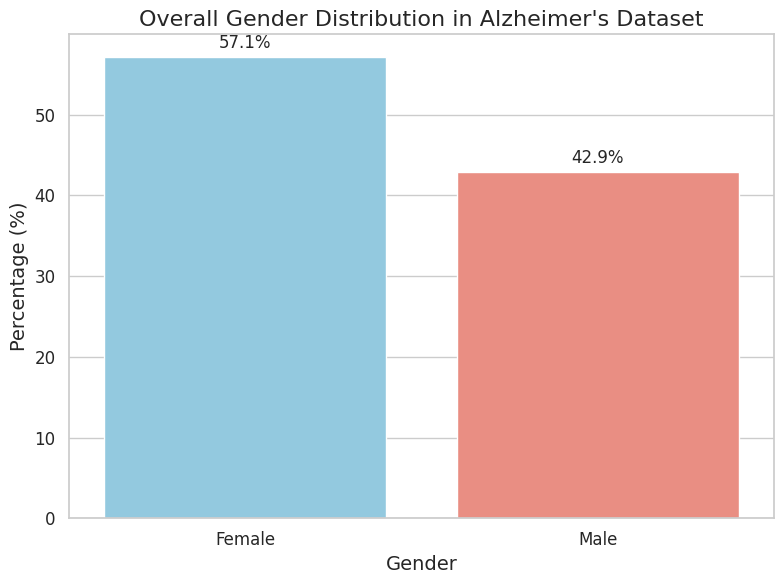

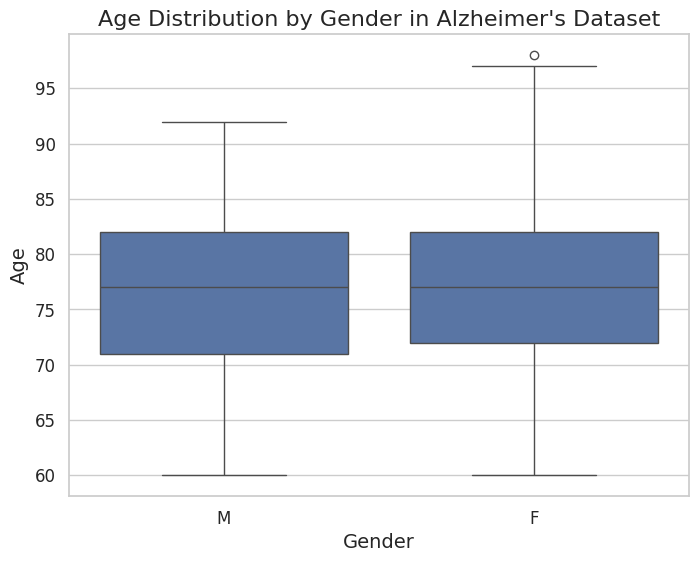


Gender Distribution in the Nondemented group:


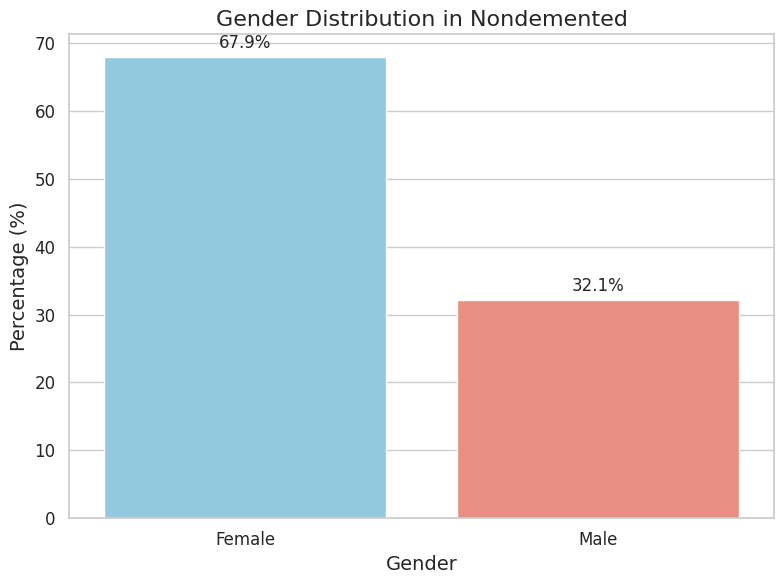


Gender Distribution in the Demented group:


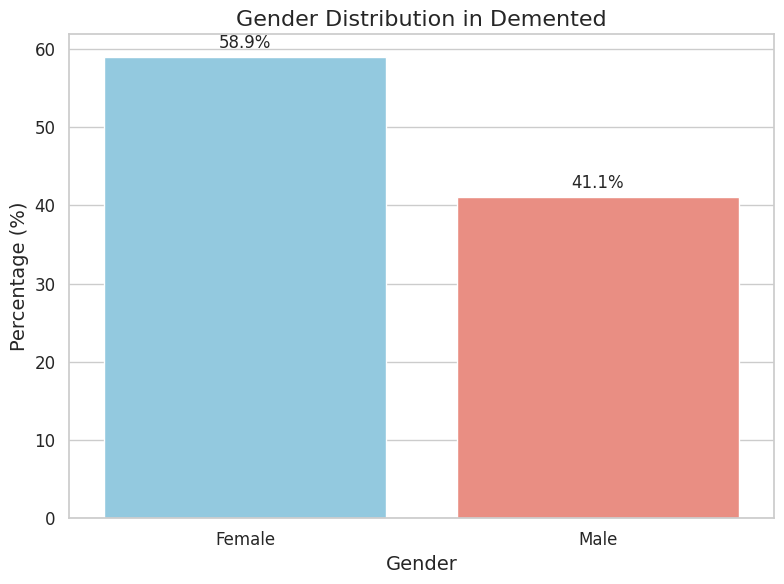


Gender Distribution in the Converted group:


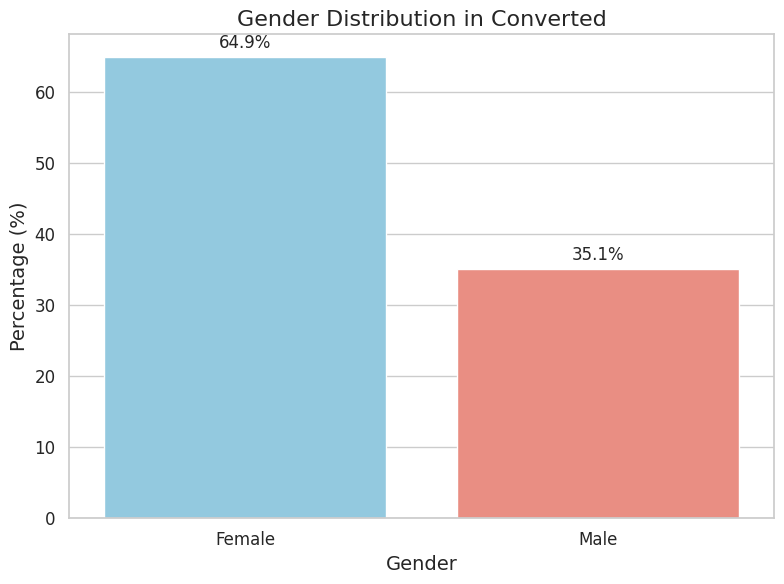

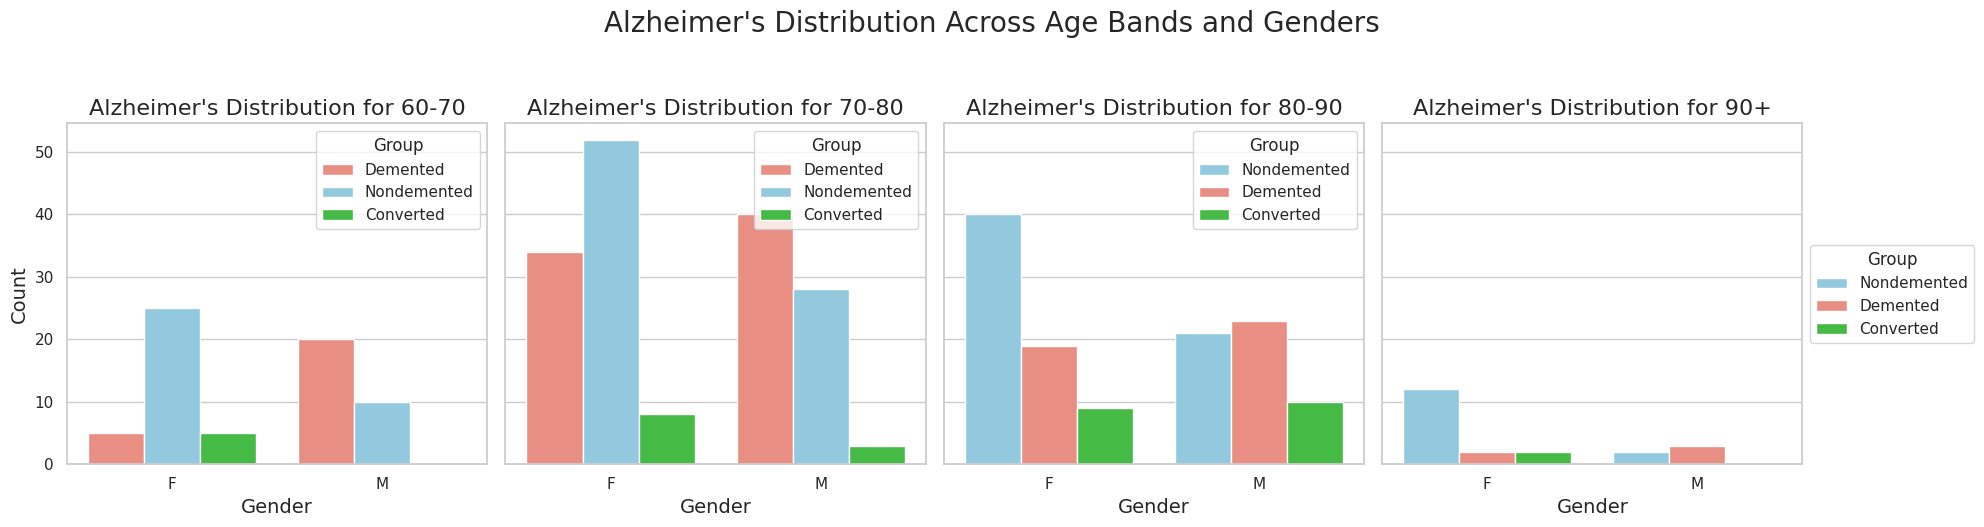

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

alzheimers_file = '/content/drive/MyDrive/ECSE 557 - Final Project/alzheimer.csv'
#Disreguard this line anastasis I am only running the file for a local directory on collab. Feel free to delete it if need be
alzheimers_file = '/content/alzheimer.csv'

# Set the visual style for the plots to be more professional
sns.set(style="whitegrid")

# Load the Alzheimer's dataset
df = pd.read_csv(alzheimers_file)

# Display the first few rows of the dataset
print(df.head())

# Provide basic statistics of dataset
print(df.describe())

# Define a function to plot the gender distribution with annotations
def plot_gender_distribution(data, title, xlabel, ylabel):
    # Prepare the data
    gender_distribution = data.value_counts(normalize=True).reset_index()
    gender_distribution.columns = ['Gender', 'Percentage']
    gender_distribution['Percentage'] *= 100  # Convert to percentage

    # Create the plot with adjusted size for better spacing
    plt.figure(figsize=(8, 6))
    barplot = sns.barplot(x='Gender', y='Percentage', hue='Gender', data=gender_distribution, palette=["skyblue", "salmon"], legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks=[0, 1], labels=['Female', 'Male'], fontsize=12)
    plt.yticks(fontsize=12)

    # Add annotations with adjusted font size for clarity
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.1f') + '%',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 10),
                         textcoords = 'offset points',
                         fontsize=12)

    plt.tight_layout()
    plt.show()

# Overall Gender Distribution in the Alzheimer's dataset
print("Overall Gender Distribution in the Alzheimer's Dataset:")
plot_gender_distribution(df['M/F'], 'Overall Gender Distribution in Alzheimer\'s Dataset', 'Gender', 'Percentage (%)')

# Age Distribution by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='M/F', y='Age', data=df)
plt.title('Age Distribution by Gender in Alzheimer\'s Dataset', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Gender distribution for each group in the dataset
for group in df['Group'].unique():
    print(f"\nGender Distribution in the {group} group:")
    group_data = df[df['Group'] == group]
    plot_gender_distribution(group_data['M/F'], f'Gender Distribution in {group}', 'Gender', 'Percentage (%)')

# Define age bands
bins = [60, 70, 80, 90, 100]
labels = ['60-70', '70-80', '80-90', '90+']
df['AgeBand'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Define consistent colors for each group
group_colors = {'Nondemented': 'skyblue', 'Demented': 'salmon', 'Converted': 'limegreen'}

# Initialize the subplot
fig, axs = plt.subplots(1, len(labels), figsize=(20, 5), sharey=True)

# Ensure consistent ordering of 'M' and 'F'
gender_order = ['F', 'M']

for i, age_band in enumerate(labels):
    # Filter data by age band
    age_band_data = df[df['AgeBand'] == age_band]

    # Create the plot for the current age band
    sns.countplot(x='M/F', hue='Group', data=age_band_data, palette=group_colors, ax=axs[i], order=gender_order)
    axs[i].set_title(f'Alzheimer\'s Distribution for {age_band}', fontsize=16)
    axs[i].set_xlabel('Gender', fontsize=14)
    if i == 0:  # Only add y label to the first subplot to avoid repetition
        axs[i].set_ylabel('Count', fontsize=14)
    else:
        axs[i].set_ylabel('')

# Place the legend on the right side of the last subplot
axs[-1].legend(title='Group', loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Alzheimer\'s Distribution Across Age Bands and Genders', fontsize=20, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the layout to make room for the legend
plt.show()

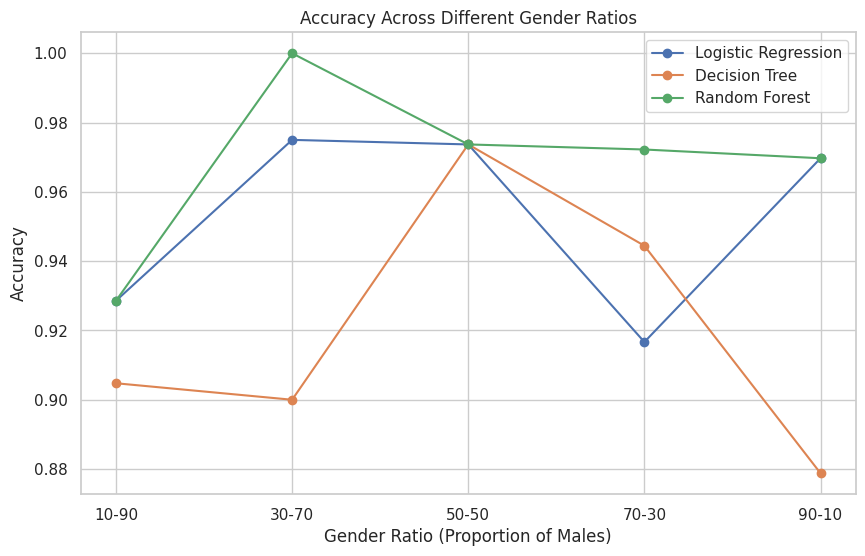

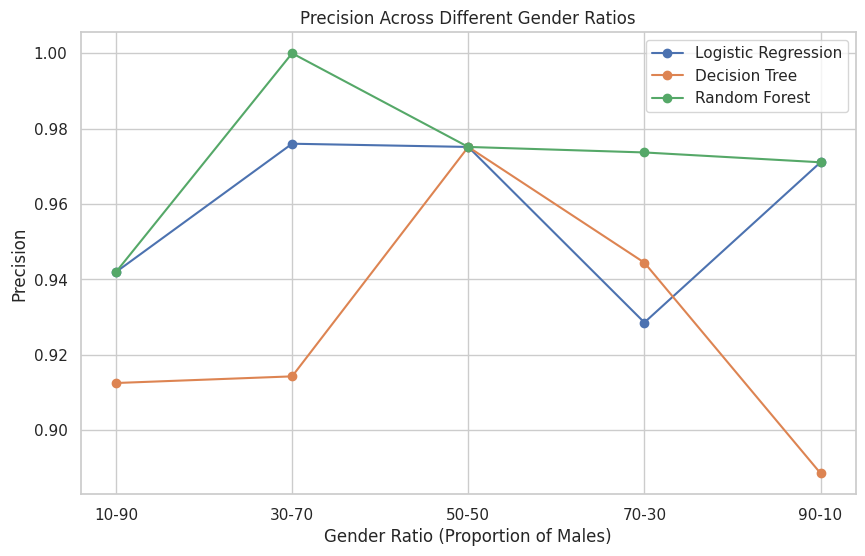

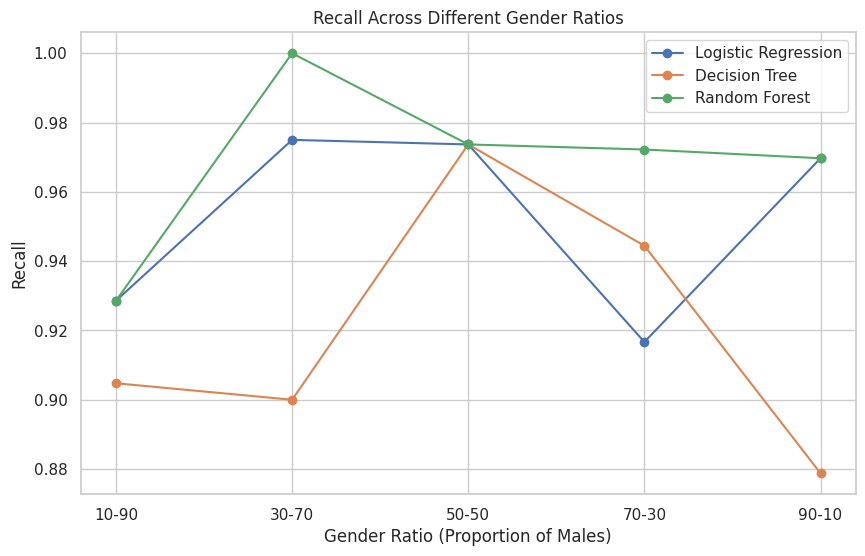

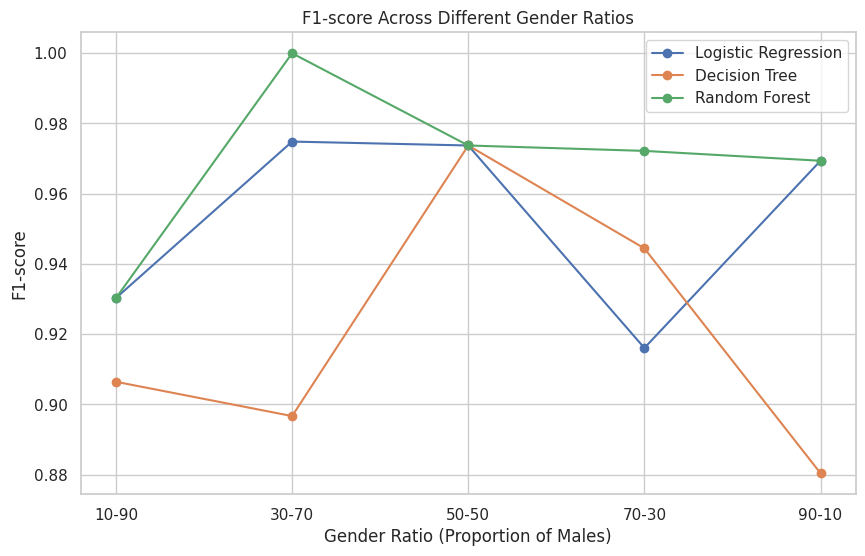

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict
import numpy as np

# Data preprocessing
df['SES'].fillna(df['SES'].median(), inplace=True)
df['MMSE'].fillna(df['MMSE'].median(), inplace=True)
df['Gender'] = df['M/F'].apply(lambda x: 1 if x == 'M' else 0)
df['Group'] = df['Group'].apply(lambda x: 1 if x == 'Demented' else 0)

def create_gender_subsets(data, ratios):
    subsets = {}
    for ratio in ratios:
        males = data[data['Gender'] == 1]
        females = data[data['Gender'] == 0]
        male_subset = males.sample(frac=ratio, random_state=42)
        female_subset = females.sample(frac=1-ratio, random_state=42)
        subset = pd.concat([male_subset, female_subset]).sample(frac=1, random_state=42)
        subsets[ratio] = subset
    return subsets

ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
ratios = np.linspace(0.1, 0.9, num=5) #Feel free to delete this line anastasis.
gender_subsets = create_gender_subsets(df, ratios)

scaler = StandardScaler()
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

metrics = defaultdict(lambda: defaultdict(dict))

for ratio, subset in gender_subsets.items():
    features = subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Gender']]
    target = subset['Group']
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        metrics[name][ratio]['Accuracy'] = accuracy_score(y_test, y_pred)
        metrics[name][ratio]['Precision'] = report['weighted avg']['precision']
        metrics[name][ratio]['Recall'] = report['weighted avg']['recall']
        metrics[name][ratio]['F1-score'] = report['weighted avg']['f1-score']

# Plotting
def plot_metrics(metrics, metric_name):
    plt.figure(figsize=(10, 6))
    for model in models.keys():
        values = [metrics[model][ratio][metric_name] for ratio in ratios]
        plt.plot(ratios, values, marker='o', label=model)
    plt.title(f'{metric_name} Across Different Gender Ratios')
    plt.xlabel('Gender Ratio (Proportion of Males)')
    plt.ylabel(metric_name)
    plt.xticks(ratios, [f"{int(r*100)}-{100-int(r*100)}" for r in ratios])
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting Accuracy, Precision, Recall, and F1-score
plot_metrics(metrics, 'Accuracy')
plot_metrics(metrics, 'Precision')
plot_metrics(metrics, 'Recall')
plot_metrics(metrics, 'F1-score')

### Stacked model

#### Accuracy / Precision / Recall / F1 score for different gender splits

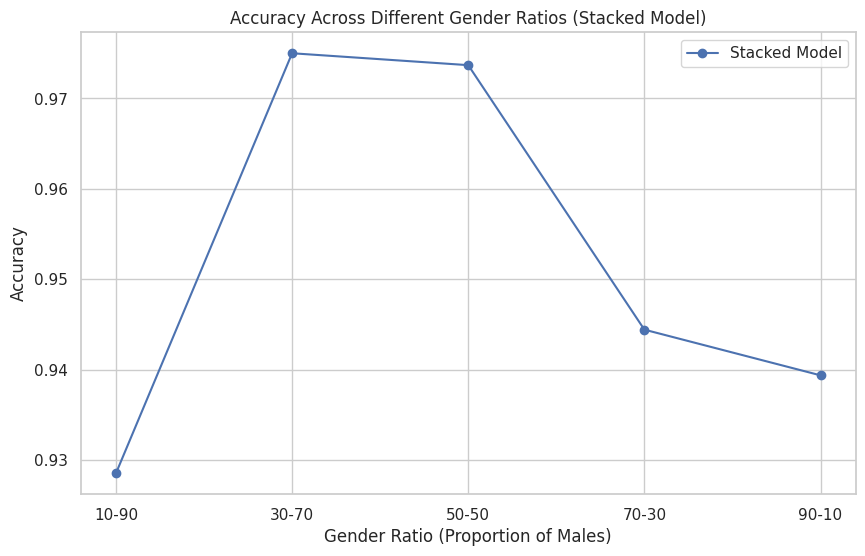

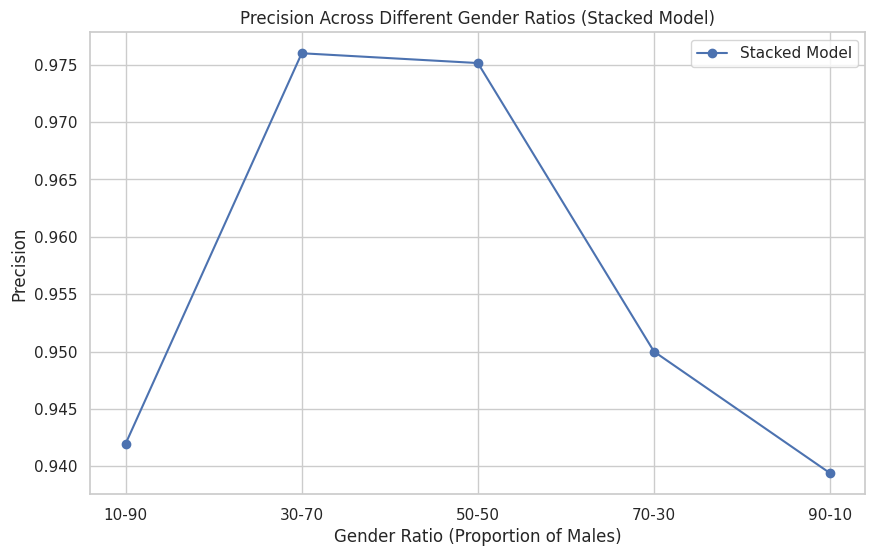

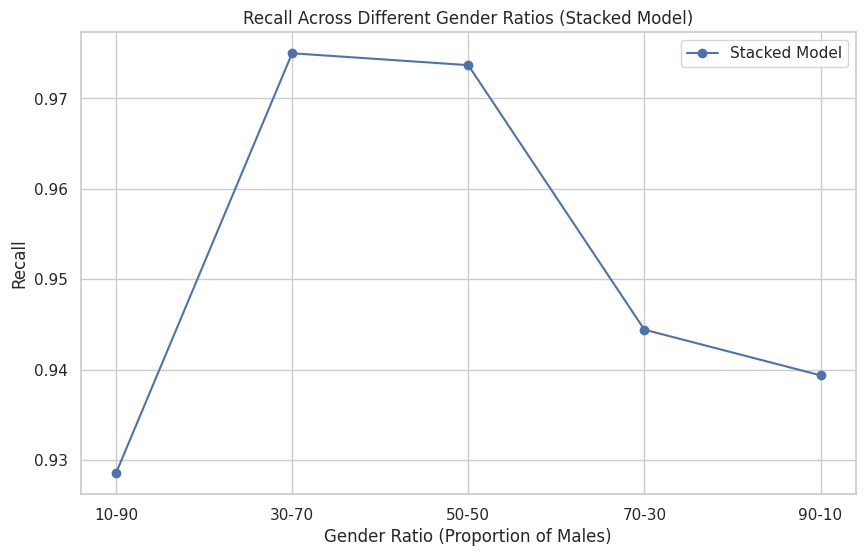

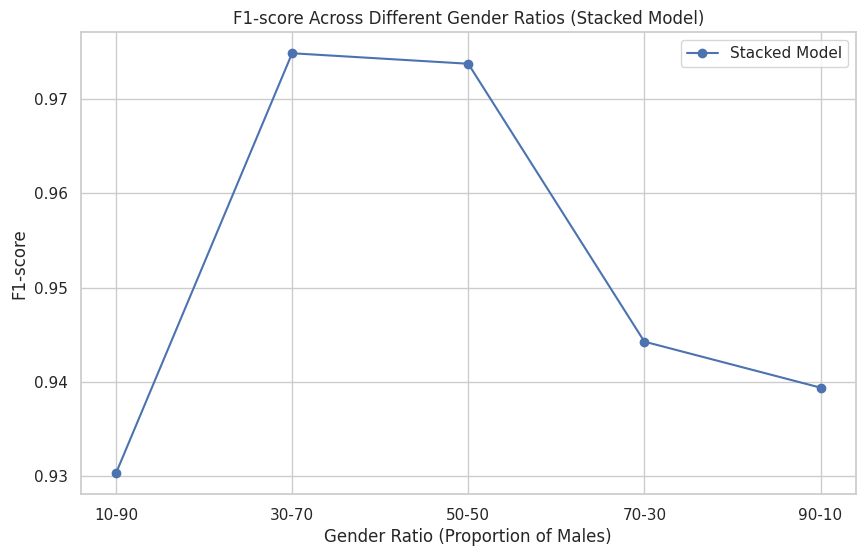

In [ ]:
from sklearn.ensemble import StackingClassifier

# Stacked Classifier
stacked_model = StackingClassifier(estimators=list(models.items()), final_estimator=LogisticRegression())

# Metrics dictionary for stacked model
stacked_metrics = defaultdict(lambda: defaultdict(dict))

for ratio, subset in gender_subsets.items():
    features = subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Gender']]
    target = subset['Group']
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacked_model.fit(X_train_scaled, y_train)
    y_pred_stacked = stacked_model.predict(X_test_scaled)
    report_stacked = classification_report(y_test, y_pred_stacked, output_dict=True, zero_division=0)
    stacked_metrics[ratio]['Accuracy'] = accuracy_score(y_test, y_pred_stacked)
    stacked_metrics[ratio]['Precision'] = report_stacked['weighted avg']['precision']
    stacked_metrics[ratio]['Recall'] = report_stacked['weighted avg']['recall']
    stacked_metrics[ratio]['F1-score'] = report_stacked['weighted avg']['f1-score']

# Plotting for stacked model
def plot_stacked_metrics(metrics, metric_name):
    plt.figure(figsize=(10, 6))
    values = [metrics[ratio][metric_name] for ratio in ratios]
    plt.plot(ratios, values, marker='o', label='Stacked Model')
    plt.title(f'{metric_name} Across Different Gender Ratios (Stacked Model)')
    plt.xlabel('Gender Ratio (Proportion of Males)')
    plt.ylabel(metric_name)
    plt.xticks(ratios, [f"{int(r*100)}-{100-int(r*100)}" for r in ratios])
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting Accuracy, Precision, Recall, and F1-score for the stacked model
plot_stacked_metrics(stacked_metrics, 'Accuracy')
plot_stacked_metrics(stacked_metrics, 'Precision')
plot_stacked_metrics(stacked_metrics, 'Recall')
plot_stacked_metrics(stacked_metrics, 'F1-score')


#### ROC curves


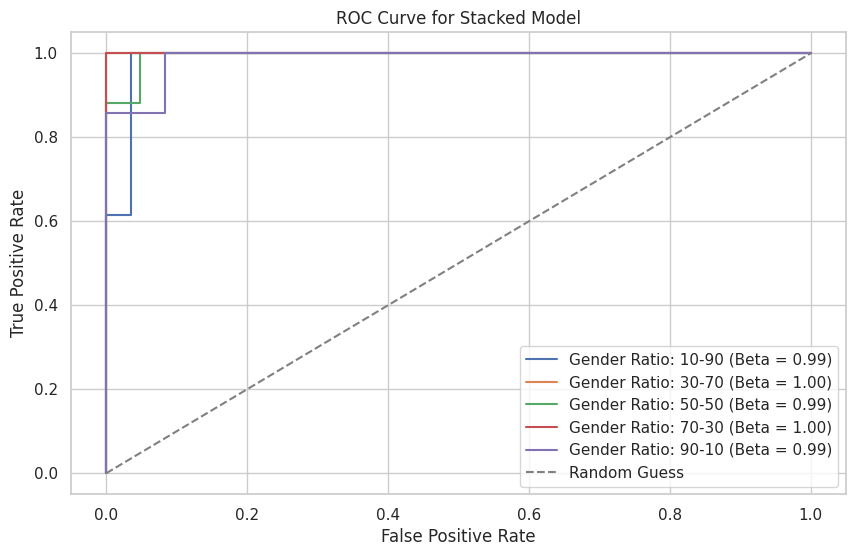

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Dictionary to store ROC data for each gender split
roc_data = {}

# Loop through each gender split
for ratio, subset in gender_subsets.items():
    features = subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Gender']]
    target = subset['Group']
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the stacked model
    stacked_model.fit(X_train_scaled, y_train)

    # Get the probabilities of the positive class (class 1)
    y_prob_stacked = stacked_model.predict_proba(X_test_scaled)[:, 1]

    # Compute the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob_stacked)
    roc_auc = auc(fpr, tpr)

    # Store ROC data
    roc_data[ratio] = (fpr, tpr, roc_auc)

# Plotting ROC curves for each gender split
plt.figure(figsize=(10, 6))
for ratio, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'Gender Ratio: {int(ratio*100)}-{100-int(ratio*100)} (Beta = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacked Model')
plt.legend()
plt.grid(True)
plt.show()


#### Bias calculation

In [ ]:
from mlxtend.evaluate import bias_variance_decomp
import numpy as np
from sklearn import metrics

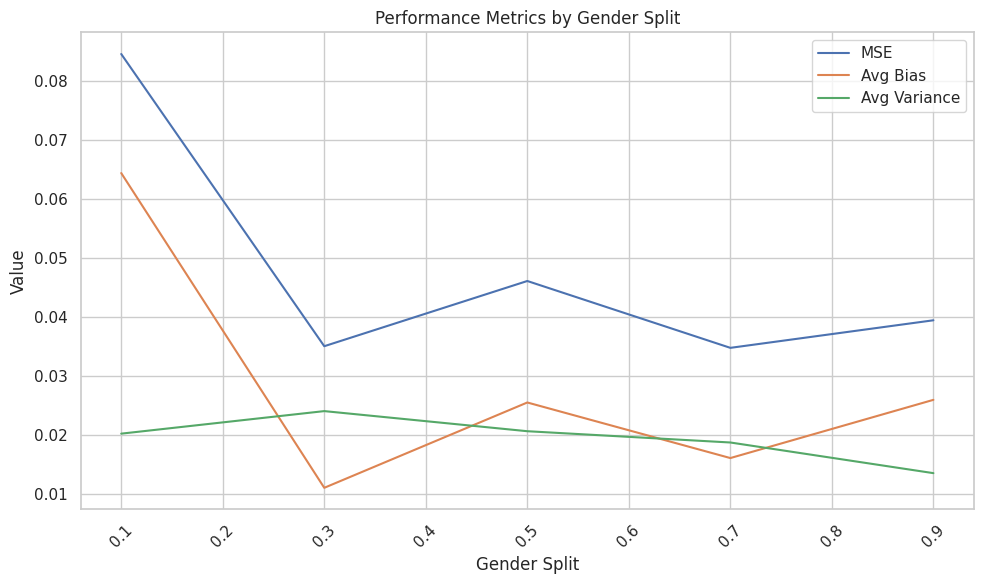

In [ ]:


# Lists to store values for plotting
mse_values = []
bias_values = []
variance_values = []
mean_squared_error_values = []

# Loop through each gender split
for ratio, subset in gender_subsets.items():
    features = subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Gender']]
    target = subset['Group']
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to NumPy arrays
    X_train_scaled = np.array(X_train_scaled)
    X_test_scaled = np.array(X_test_scaled)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Stacked Classifier
    stacked_model = StackingClassifier(estimators=list(models.items()), final_estimator=LogisticRegression())

    # Train the stacked model
    stacked_model.fit(X_train_scaled, y_train)

    mse, bias, var = bias_variance_decomp(stacked_model, X_train_scaled, y_train, X_test_scaled, y_test, loss='mse', num_rounds=20, random_seed=123)
    y_pred = stacked_model.predict(X_test_scaled)

    # Append values to lists
    mse_values.append(mse)
    bias_values.append(bias)
    variance_values.append(var)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(list(gender_subsets.keys()), mse_values, label='MSE')
plt.plot(list(gender_subsets.keys()), bias_values, label='Avg Bias')
plt.plot(list(gender_subsets.keys()), variance_values, label='Avg Variance')

plt.title('Performance Metrics by Gender Split')
plt.xlabel('Gender Split')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



{0.1: -0.029559220019746313, 0.30000000000000004: 0.02847649426596799, 0.5: 0.02683175742386268, 0.7000000000000001: -0.009717950178476542, 0.9: -0.016031081491607813}


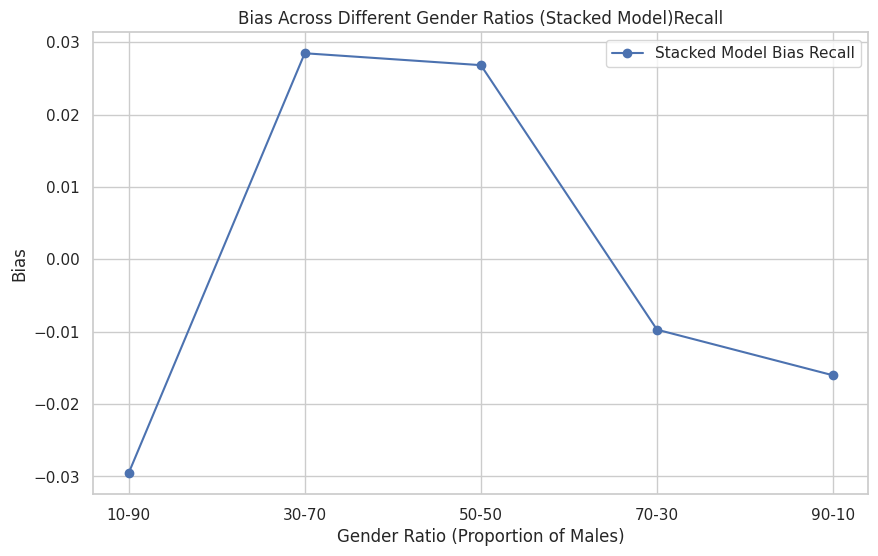

{0.1: -0.0277464139865361, 0.30000000000000004: 0.027920983926213894, 0.5: 0.02653017127584023, 0.7000000000000001: -0.010303304091200283, 0.9: -0.01640143712431763}


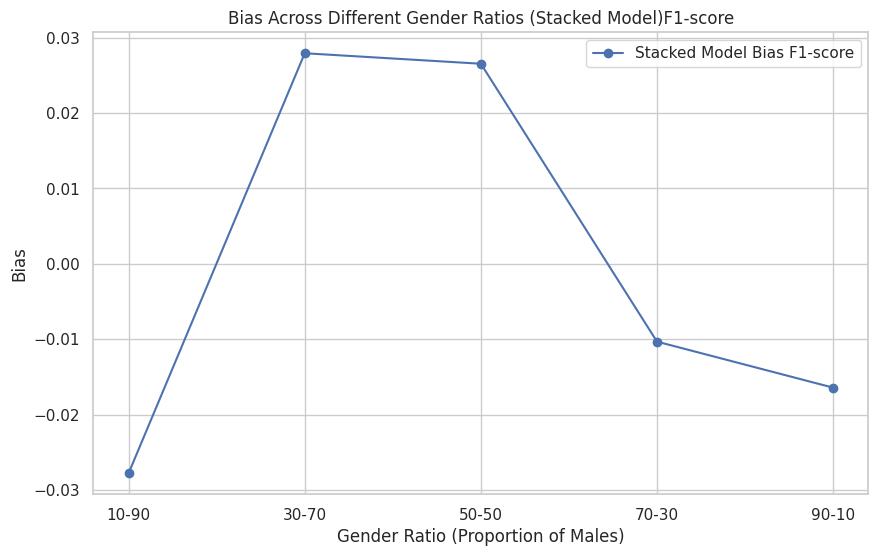

{0.1: -0.029559220019746313, 0.30000000000000004: 0.02847649426596799, 0.5: 0.02683175742386268, 0.7000000000000001: -0.009717950178476542, 0.9: -0.016031081491607813}


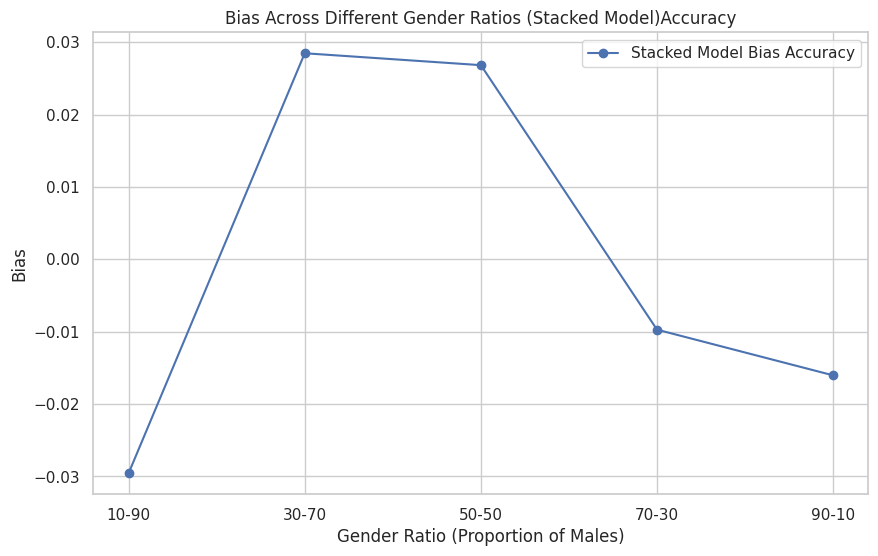

{0.1: -0.018170748841801587, 0.30000000000000004: 0.02437389401534129, 0.5: 0.02330664255335313, 0.7000000000000001: -0.008126105984658571, 0.9: -0.021383681742234373}


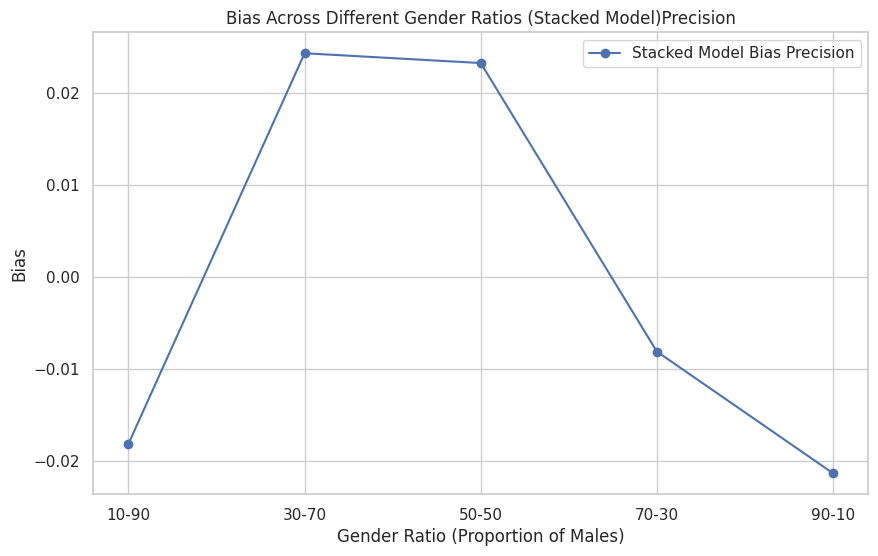

In [ ]:

# Bias calculation for the stacked model
# We here define as bias the difference between the value of the metric (here accuracy) for a particular gender split and the mean
# of the means of all the other splits.
def calculate_bias(metrics, metric_name, ratios):
    bias = {}
    for i, ratio in enumerate(ratios):
        current_metric = metrics[ratio][metric_name]
        other_metrics = [metrics[r] for r in ratios if r != ratio]
        mean_other_metrics = np.mean([value[metric_name] for value in other_metrics])
        bias[ratio] = current_metric - mean_other_metrics
    return bias



# Bias for the stacked model
listMetric = ['Recall', 'F1-score', 'Accuracy', 'Precision']
for metric in listMetric:
  stacked_bias = calculate_bias(stacked_metrics, metric, ratios)
  print(stacked_bias)

  # Plotting for bias of stacked model
  plt.figure(figsize=(10, 6))
  plt.plot(list(stacked_bias.keys()), list(stacked_bias.values()), marker='o', label=f'Stacked Model Bias {metric}')
  plt.title(f'Bias Across Different Gender Ratios (Stacked Model){metric}')
  plt.xlabel('Gender Ratio (Proportion of Males)')
  plt.ylabel('Bias')
  plt.xticks(list(stacked_bias.keys()), [f"{int(r*100)}-{100-int(r*100)}" for r in ratios])
  plt.legend()
  plt.grid(True)
  plt.show()



In [ ]:
import numpy as np

def calculate_bias_overall(metrics, metric_list, ratios):
    final_output = {}
    list_dict = []

    # Iterate over each metric in the metric_list
    for metric_name in metric_list:
        bias_values = []  # List to store bias values for current metric
        stacked_bias = calculate_bias(metrics, metric_name, ratios)  # Calculate bias for current metric and ratios
        list_dict.append(stacked_bias)

    # Iterate over each dictionary in the list_dict
    for d in list_dict:
        # Iterate over each key in the dictionary
        for key in d:
            # Calculate the average value for the current key across all dictionaries
            if key in final_output:
                final_output[key].append(d[key])
            else:
                final_output[key] = [d[key]]

    for key in final_output:
        final_output[key] = np.mean(final_output[key])

    return final_output



# Bias for the stacked model
listMetric = ['Recall', 'F1-score', 'Accuracy', 'Precision']
stacked_bias_values = calculate_bias_overall(stacked_metrics, listMetric, ratios)
stacked_bias_values




{0.1: -0.02625890071695758,
 0.30000000000000004: 0.02731196661837279,
 0.5: 0.02587508216922968,
 0.7000000000000001: -0.009466327608202985,
 0.9: -0.017461820462441907}

#### Fairness metrics


In [ ]:
# Metrics function. Code provided in the tutorial 7 : Fairness II.

def compute_metrics(dataset_true, dataset_pred,
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Accuracy between unprivileged and privileged groups"] = classified_metric_pred.accuracy()
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average Odds Difference between unprivileged and privileged group"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    metrics["True Positive Rate difference between unprivileged and privileged groups"] = classified_metric_pred.true_positive_rate_difference()
    #metrics["False Negative Rate ratio between unprivileged and privileged groups"] = classified_metric_pred.false_negative_rate_ratio()


    return metrics

In [ ]:
from sklearn.ensemble import StackingClassifier

# Stacked Classifier
stacked_model = StackingClassifier(estimators=list(models.items()), final_estimator=LogisticRegression())

# Metrics dictionary for stacked model
stacked_metrics = defaultdict(lambda: defaultdict(dict))
metrics_dict = {}

for ratio, subset in gender_subsets.items():
    features = subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Gender']]
    target = subset['Group']
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    stacked_model.fit(X_train_scaled, y_train)
    predictions = stacked_model.predict(X_test_scaled)

        # Creating DataFrames with features
    real_values_df = X_test.join(y_test) #real values df is the original test dataset
    predictions_df = real_values_df.copy()

    #Creating the dataframe with the predictions
    predictions_df['Group'] = predictions



    #Highlighting the privileged group (1 : Male) from the unprivileged one (0 : F).
    privileged_groups = [{'Gender': 0}] #To be debated
    unprivileged_groups = [{'Gender': 1}] #To be debated



    #Creating Datasets in the format of a BinaryLabelDataset
    real_values_BLD = BinaryLabelDataset(df = real_values_df,
                                  favorable_label = 1,
                                  unfavorable_label = 0,
                                  label_names = ['Group'],
                                  protected_attribute_names = ['Gender'])

    predictions_BLD = BinaryLabelDataset(df = predictions_df,
                                  favorable_label = 1,
                                  unfavorable_label = 0,
                                  label_names = ['Group'],
                                  protected_attribute_names = ['Gender'])

    #metrics_dict[f'ratio = {ratio}'] = compute_metrics(real_values_BLD, predictions_BLD,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
    metrics_dict[ratio] = compute_metrics(real_values_BLD, predictions_BLD,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)






/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


In [ ]:
metrics_dict

{0.1: OrderedDict([('Balanced accuracy', 0.9482758620689655),
              ('Accuracy between unprivileged and privileged groups',
               0.9285714285714286),
              ('Statistical parity difference', -0.4),
              ('Disparate impact', 0.0),
              ('Average Odds Difference between unprivileged and privileged group',
               nan),
              ('Equal opportunity difference', nan),
              ('Theil index', 0.023426752587707943),
              ('True Positive Rate difference between unprivileged and privileged groups',
               nan)]),
 0.30000000000000004: OrderedDict([('Balanced accuracy', 0.96875),
              ('Accuracy between unprivileged and privileged groups', 0.975),
              ('Statistical parity difference', 0.23297491039426527),
              ('Disparate impact', 1.7222222222222223),
              ('Average Odds Difference between unprivileged and privileged group',
               -0.08333333333333331),
              ('Eq

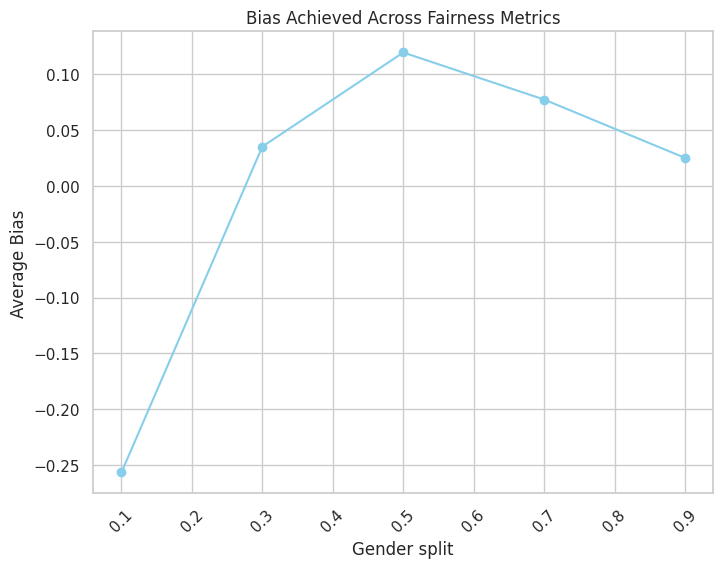

In [ ]:
import matplotlib.pyplot as plt

# List of metric names and ratios
metric_list = ['Balanced accuracy', 'Accuracy between unprivileged and privileged groups', 'Statistical parity difference']

# Calculate bias values overall
bias_overall = calculate_bias_overall(metrics_dict, metric_list, ratios)

# Extract keys and values from the dictionary
keys = list(bias_overall.keys())
values = list(bias_overall.values())

# Plot the data as a curve
plt.figure(figsize=(8, 6))
plt.plot(keys, values, color='skyblue', marker='o')  # Plotting as a curve with markers at data points
plt.xlabel('Gender split')
plt.ylabel('Average Bias')
plt.title('Bias Achieved Across Fairness Metrics')
plt.xticks(rotation=45)
plt.grid(True)  # Add grid lines for better readability
plt.show()


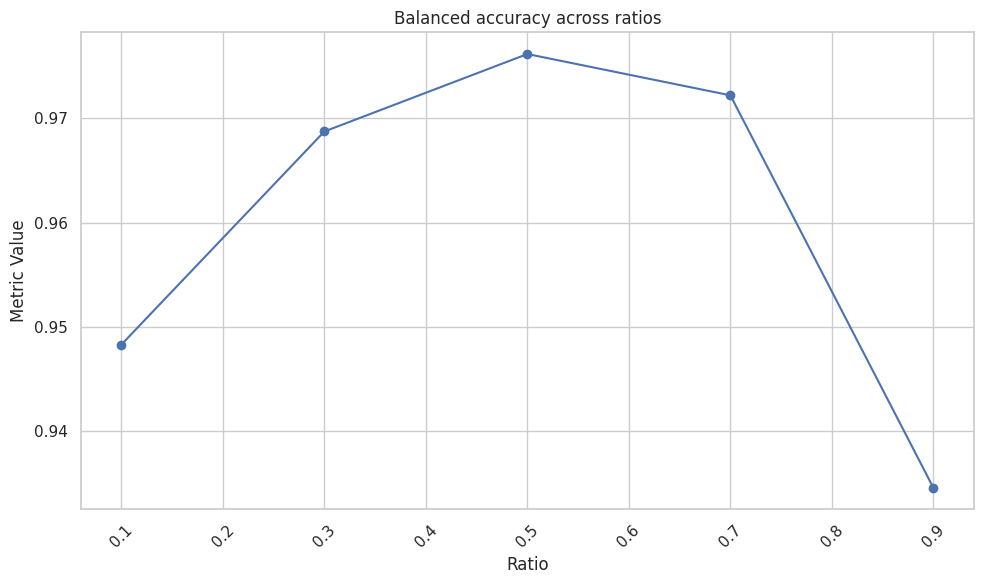

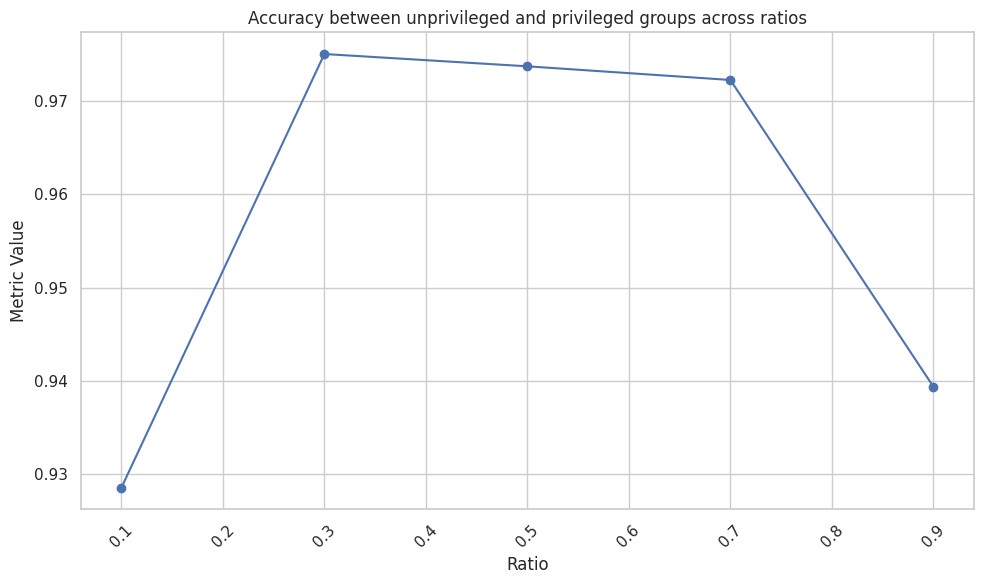

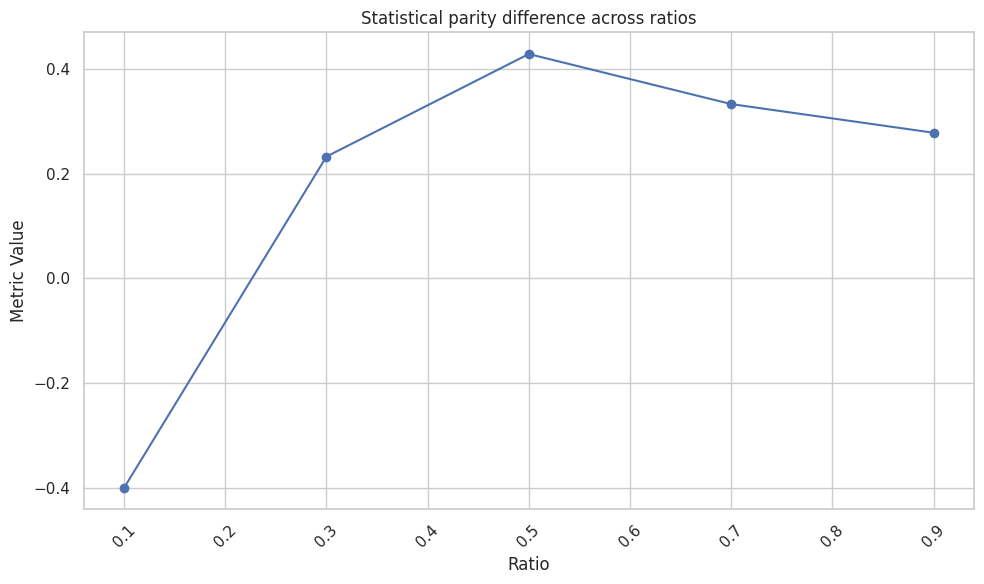

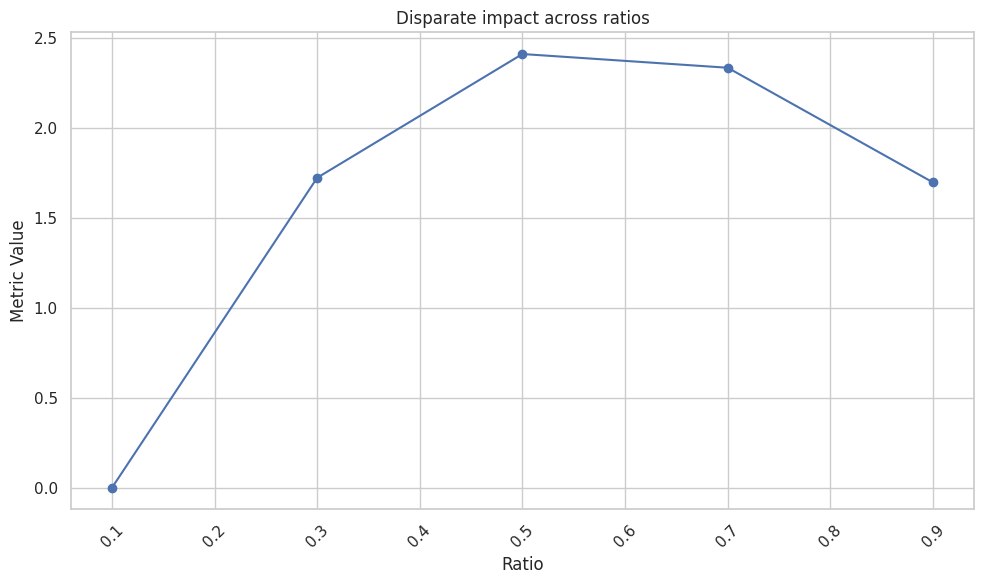

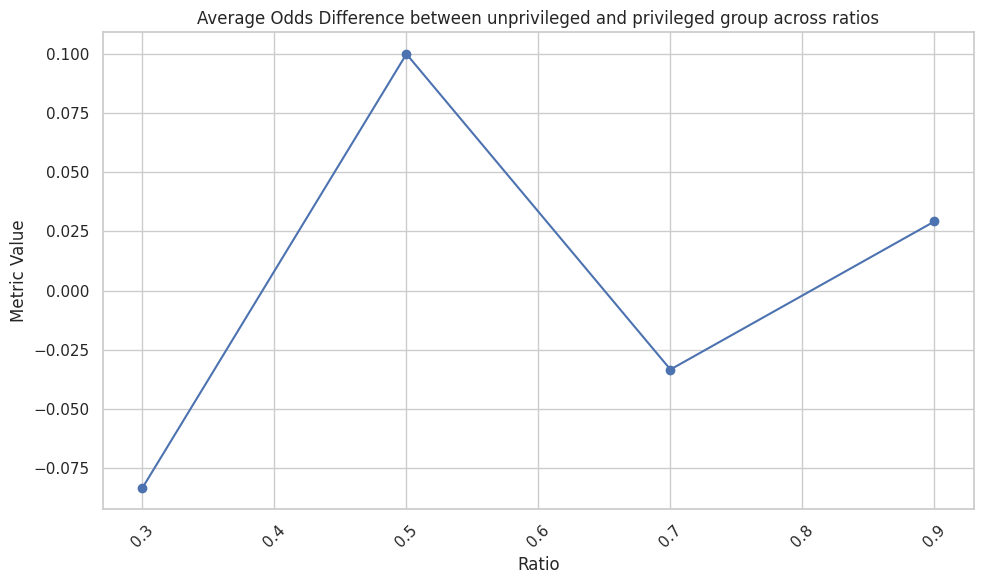

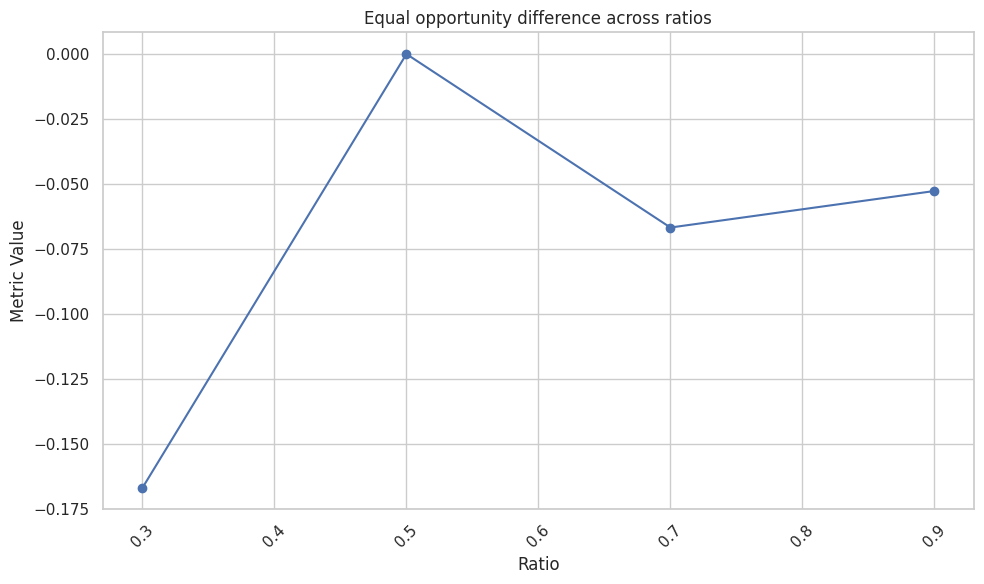

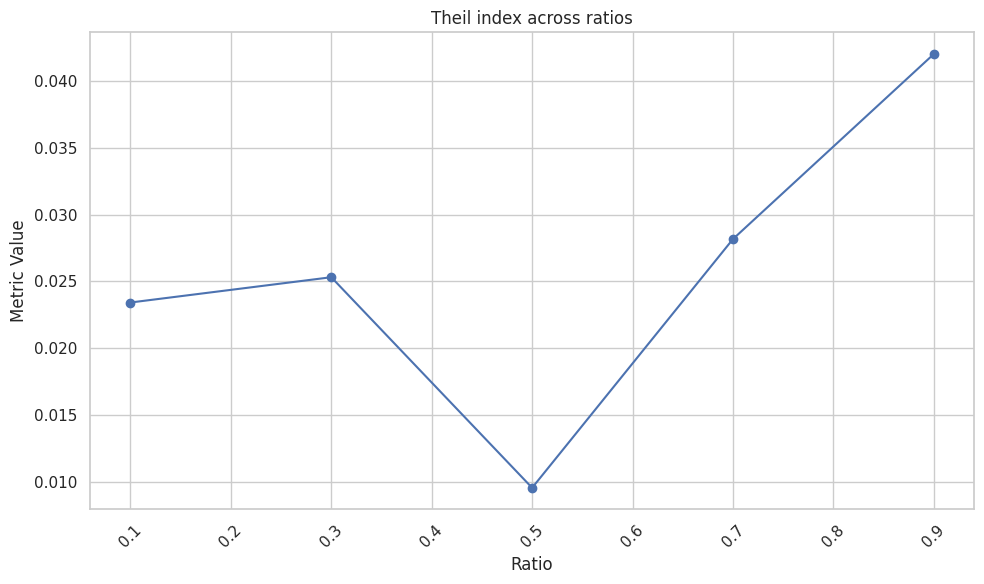

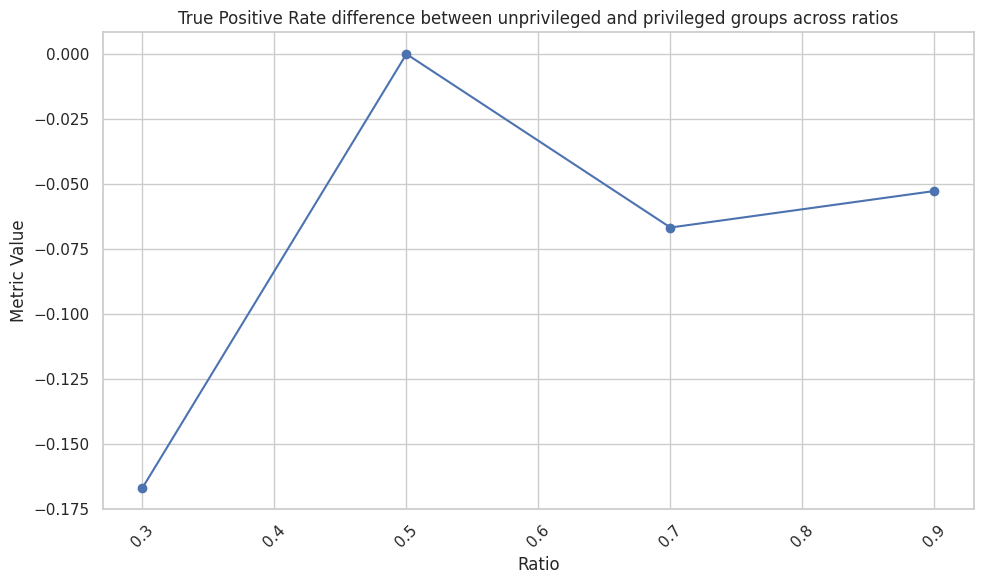

In [ ]:
import matplotlib.pyplot as plt

def plot_metric_across_splits(metric_name, metric_values, ratio_values):
    """ Plot a metric across all gender splits """
    plt.figure(figsize=(10, 6))
    plt.plot(ratio_values, metric_values, linestyle='-', marker='o')  # Plot all points for a metric together
    plt.xlabel('Ratio')
    plt.ylabel('Metric Value')
    plt.title(f'{metric_name} across ratios')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Extract metric names
metric_names = list(metrics_dict[0.1].keys())



# Iterate over metric names and plot each metric across ratios
for metric_name in metric_names:
    metric_values = [metric_dict[metric_name] for metric_dict in metrics_dict.values()]
    plot_metric_across_splits(metric_name, metric_values, ratios)




#### Reweighting

In [ ]:
from sklearn.ensemble import StackingClassifier
# Fairness preprocessing
from aif360.algorithms.preprocessing import Reweighing



# Stacked Classifier
stacked_model = StackingClassifier(estimators=list(models.items()), final_estimator=LogisticRegression())

# Metrics dictionary for stacked model
stacked_metrics = defaultdict(lambda: defaultdict(dict))
metrics_dict_rw = {}

for ratio, subset in gender_subsets.items():
    features = subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Gender']]
    target = subset['Group']


    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    stacked_model.fit(X_train_scaled, y_train)
    predictions = stacked_model.predict(X_test_scaled)

        # Creating DataFrames with features
    real_values_df = X_test.join(y_test) #real values df is the original test dataset
    predictions_df = real_values_df.copy()

    #Creating the dataframe with the predictions
    predictions_df['Group'] = predictions



    #Highlighting the privileged group (1 : Male) from the unprivileged one (0 : F).
    privileged_groups = [{'Gender': 0}] #To be debated
    unprivileged_groups = [{'Gender': 1}] #To be debated



    #Creating Datasets in the format of a BinaryLabelDataset
    real_values_BLD = BinaryLabelDataset(df = real_values_df,
                                  favorable_label = 1,
                                  unfavorable_label = 0,
                                  label_names = ['Group'],
                                  protected_attribute_names = ['Gender'])

    predictions_BLD = BinaryLabelDataset(df = predictions_df,
                                  favorable_label = 1,
                                  unfavorable_label = 0,
                                  label_names = ['Group'],
                                  protected_attribute_names = ['Gender'])



    '''
    Reweighting chunk
    '''
    rw = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)

    #reweighting our previous Binary Label Dataset
    rw.fit(real_values_BLD)
    rw_df = rw.transform(real_values_BLD)

    #Creating reweighted train-test sets
    x_train_rw = rw_df.features
    y_train_rw = rw_df.labels.ravel()
    x_test_rw = real_values_BLD.features
    y_test_rw = real_values_BLD.labels

    #Implementing a logistic regression model
    model = LogisticRegression()
    model.fit(x_train_rw, y_train_rw, sample_weight=rw_df.instance_weights)

    #creating a set or reweighted predictions set from our model
    rw_predictions = model.predict(X_test_scaled)
    rw_test_df = real_values_df.copy()
    rw_test_df['Group'] = rw_predictions


    #Creating a Binary Label Dataset from our predictions
    rw_predicted_data =  BinaryLabelDataset(df = rw_test_df,
                                  favorable_label = 1,
                                  unfavorable_label = 0,
                                  label_names = ['Group'],
                                  protected_attribute_names = ['Gender'])


    metrics_dict_rw[ratio] = compute_metrics(real_values_BLD, rw_predicted_data,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)


/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/reweighing.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: 

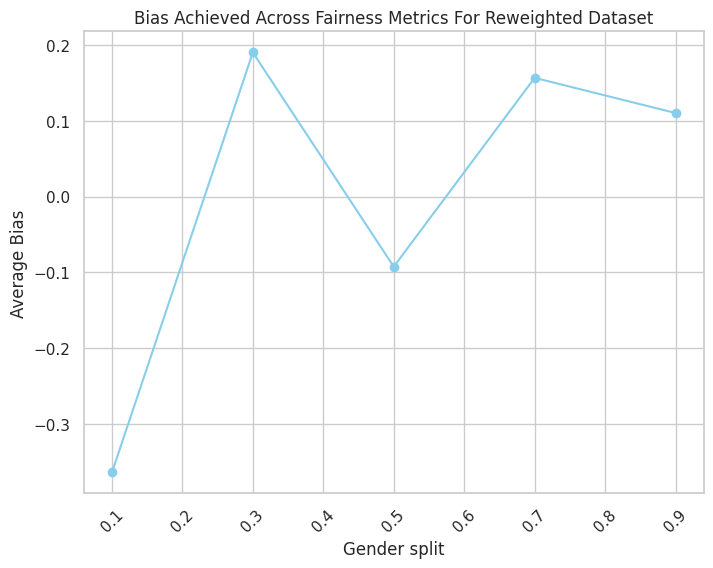

In [ ]:

import matplotlib.pyplot as plt

# List of metric names and ratios
metric_list = ['Balanced accuracy', 'Accuracy between unprivileged and privileged groups', 'Statistical parity difference']

# Calculate bias values overall
bias_overall = calculate_bias_overall(metrics_dict_rw, metric_list, ratios)

# Extract keys and values from the dictionary
keys = list(bias_overall.keys())
values = list(bias_overall.values())

# Plot the data as a curve
plt.figure(figsize=(8, 6))
plt.plot(keys, values, color='skyblue', marker='o')  # Plotting as a curve with markers at data points
plt.xlabel('Gender split')
plt.ylabel('Average Bias')
plt.title('Bias Achieved Across Fairness Metrics For Reweighted Dataset')
plt.xticks(rotation=45)
plt.grid(True)  # Add grid lines for better readability
plt.show()

# Stroke Dataset

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
                 id          age  hypertension  heart_di

<ipython-input-82-cd4e94d8e1b7>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Female', 'Male'])  # Assuming 'gender' has 'Female' and 'Male' categories
<ipython-input-82-cd4e94d8e1b7>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Female', 'Male'])  # Assuming 'gender' has 'Female' and 'Male' categories
<ipython-input-82-cd4e94d8e1b7>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Female', 'Male'])  # Assuming 'gender' has 'Female' and 'Male' categories
<ipython-input-82-cd4e94d8e1b7>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Female', 'Male'])  # Assuming 'gender' has 'Female' and 'Male' categories
<ipython-input-82-cd4e94d8e1b7>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(['Female', 'Male

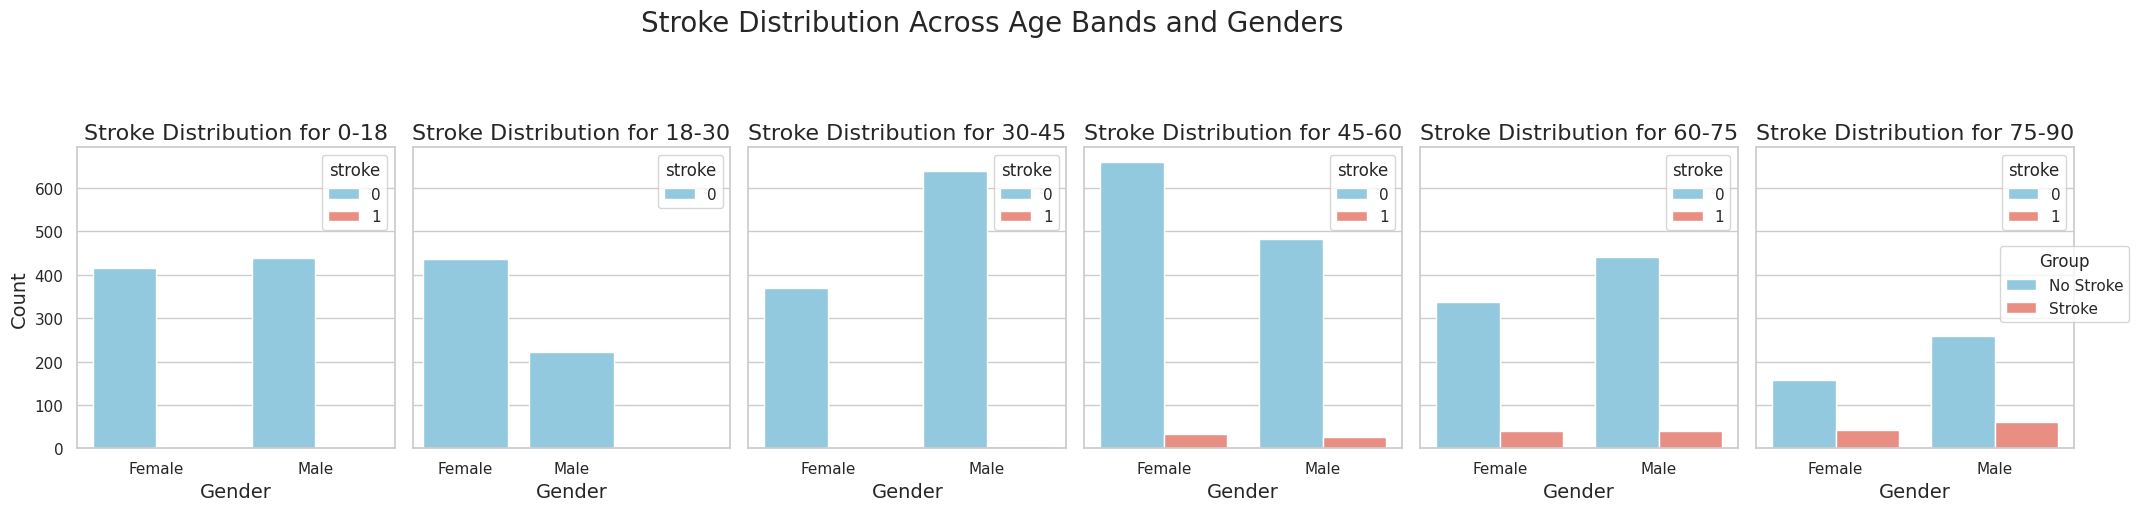

In [ ]:
stroke_file = "/content/drive/MyDrive/ECSE 557 - Final Project/healthcare-dataset-stroke-data.csv"
stroke_file = "/content/healthcare-dataset-stroke-data.csv"
# Load the stroke dataset
df = pd.read_csv(stroke_file)

# Display the first few rows of the dataset
print(df.head())

# Provide basic statistics of dataset
print(df.describe())

# Set the visual style for the plots to be more professional
sns.set(style="whitegrid")

# Define age bands (adjust the bins as needed for your stroke dataset)
bins = [0, 18, 30, 45, 60, 75, 90]
labels = ['0-18', '18-30', '30-45', '45-60', '60-75', '75-90']
df['AgeBand'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Gender distribution for each age band in the dataset
# Initialize the subplot
fig, axs = plt.subplots(1, len(labels), figsize=(20, 5), sharey=True)

# Define consistent colors for each group
stroke_colors = {0: 'skyblue', 1: 'salmon'}  # Assuming 'stroke' is a binary column in your dataset

for i, age_band in enumerate(labels):
    # Filter data by age band
    age_band_data = df[df['AgeBand'] == age_band]

    # Create the plot for the current age band
    sns.countplot(x='gender', hue='stroke', data=age_band_data, palette=stroke_colors, ax=axs[i])
    axs[i].set_title(f'Stroke Distribution for {age_band}', fontsize=16)
    axs[i].set_xlabel('Gender', fontsize=14)
    axs[i].set_xticklabels(['Female', 'Male'])  # Assuming 'gender' has 'Female' and 'Male' categories
    if i == 0:  # Only add y label to the first subplot to avoid repetition
        axs[i].set_ylabel('Count', fontsize=14)
    else:
        axs[i].set_ylabel('')

# Place the legend on the right side of the last subplot
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, ['No Stroke', 'Stroke'], title='Group', loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Stroke Distribution Across Age Bands and Genders', fontsize=20, y=1.05)
plt.tight_layout(rect=[0, 0.03, 1.05, 0.95])  # Adjust the layout to make room for the legend
plt.show()


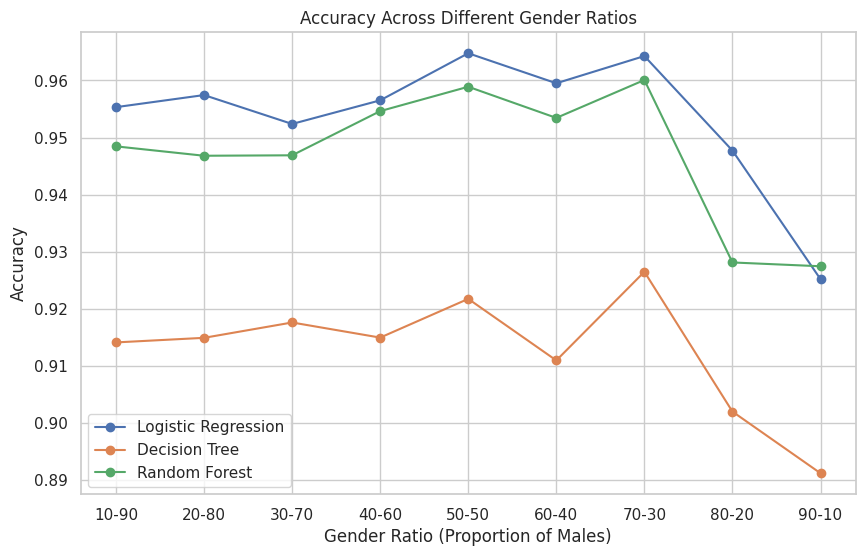

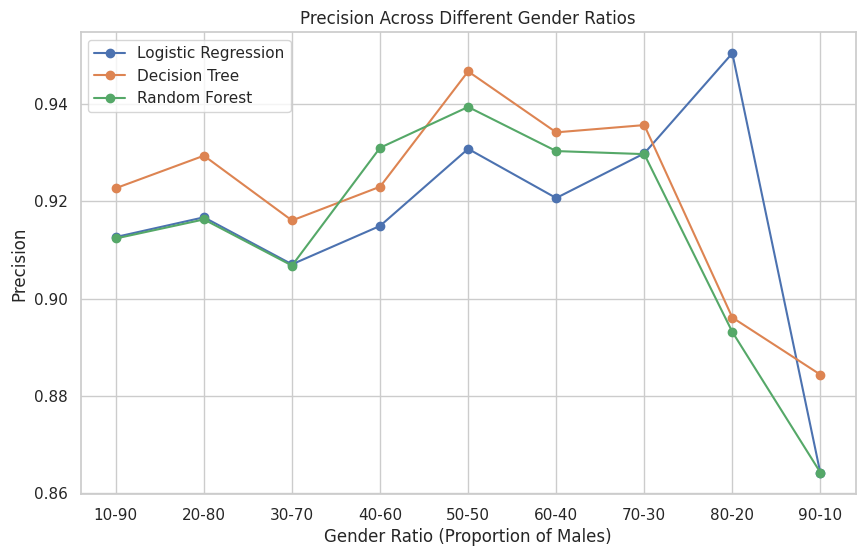

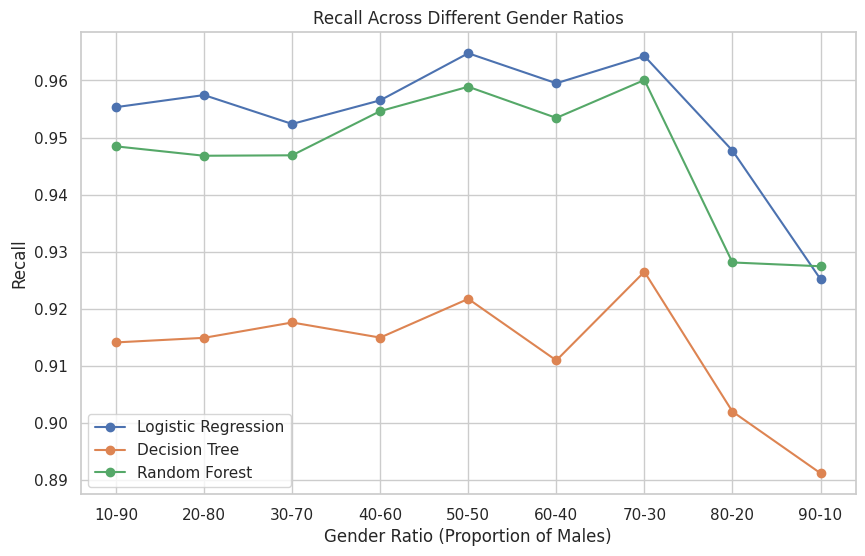

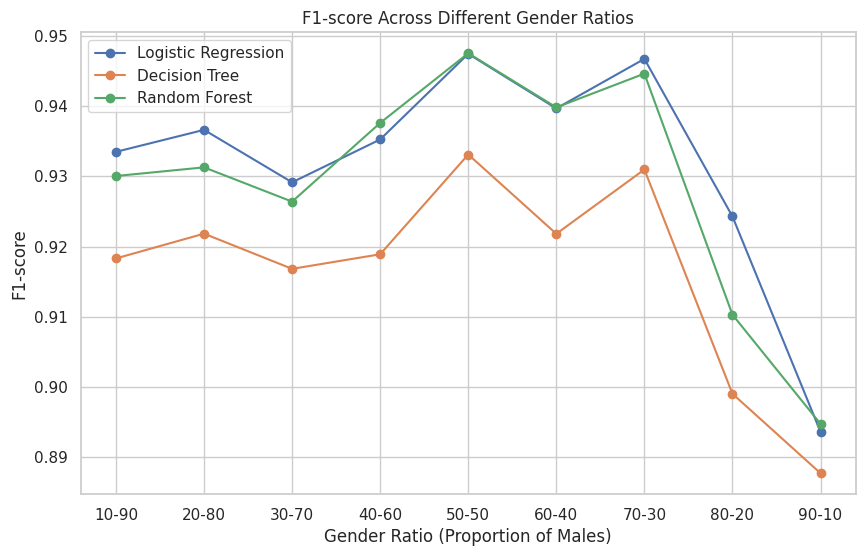

In [ ]:
stroke_file = "/content/drive/MyDrive/ECSE 557 - Final Project/healthcare-dataset-stroke-data.csv"
stroke_file = "/content/healthcare-dataset-stroke-data.csv"

# Preprocessing
df = df.drop(columns=['id'])  # Dropping the 'id' column
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Handling missing BMI values
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0, 'Other': -1})  # Encoding 'gender'
df = df[df['gender'] != -1]  # Removing 'Other' gender category

# Function to create gender subsets
def create_gender_subsets(data, ratios):
    subsets = {}
    for ratio in ratios:
        males = data[data['gender'] == 1]
        females = data[data['gender'] == 0]
        male_subset = males.sample(frac=ratio, random_state=42)
        female_subset = females.sample(frac=1-ratio, random_state=42)
        subset = pd.concat([male_subset, female_subset]).sample(frac=1, random_state=42)
        subsets[ratio] = subset
    return subsets

ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gender_subsets = create_gender_subsets(df, ratios)

# Initializing the scaler and models
scaler = StandardScaler()
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

metrics = defaultdict(lambda: defaultdict(dict))

# Training and evaluating models
for ratio, subset in gender_subsets.items():
    features = subset[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']]
    target = subset['stroke']
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        metrics[name][ratio]['Accuracy'] = accuracy_score(y_test, y_pred)
        metrics[name][ratio]['Precision'] = report['weighted avg']['precision']
        metrics[name][ratio]['Recall'] = report['weighted avg']['recall']
        metrics[name][ratio]['F1-score'] = report['weighted avg']['f1-score']

# Function to plot metrics
def plot_metrics(metrics, metric_name):
    plt.figure(figsize=(10, 6))
    for model in models.keys():
        values = [metrics[model][ratio][metric_name] for ratio in ratios]
        plt.plot(ratios, values, marker='o', label=model)
    plt.title(f'{metric_name} Across Different Gender Ratios')
    plt.xlabel('Gender Ratio (Proportion of Males)')
    plt.ylabel(metric_name)
    plt.xticks(ratios, [f"{int(r*100)}-{100-int(r*100)}" for r in ratios])
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the metrics
plot_metrics(metrics, 'Accuracy')
plot_metrics(metrics, 'Precision')
plot_metrics(metrics, 'Recall')
plot_metrics(metrics, 'F1-score')